# A COMPARATIVE ANALYSIS OF SIMPLEX AND SINKHORN ALGORITHMS IN COMPUTATIONAL OPTIMAL TRANSPORT

## MATTEO CASIRAGHI

In [2]:
#LIBRARIES

import numpy as np

from scipy.optimize import linprog 

import networkx as nx

import matplotlib.pyplot as plt

import time

import pandas as pd

from matplotlib.animation import FuncAnimation

from IPython.display import HTML

import seaborn as sns

from numpy import log

from scipy.optimize import curve_fit

#### FUNCTIONS

In [3]:
def generate_random_locations(n, x_range=(0, 5), y_range=(0, 5)):
    """Function to generate random suppliers and demanders locations"""
    
    locations = np.zeros((n, 2))
    
    for i in range(n):
        locations[i] = np.random.uniform(x_range[0], x_range[1]), np.random.uniform(y_range[0], y_range[1])
        
    return locations

In [4]:
def extract_edges(P):
    """Function to extract paths from suppliers to consumers"""

    edges = []
    
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            if P[i, j] > 0:
                edges.append((i, j))
                
    return edges

In [5]:
def generate_points(edges, locations):
    """Function to create a point for each demand satisfied by a precise supply"""
    
    points = []
    
    for edge in edges:
        points.append(locations[edge[0]])
        
    return np.array(points)

In [6]:
def generate_demand_points(locations, b):
    """Function to create demand points"""
    
    demand_points = []

    for i in range(len(b)):
        if b[i] > 0:
            demand_points.append(locations[i])

    return np.array(demand_points)

In [7]:
def plot_geographic_points(supply_points, demand_points):
    """Function to plot supply and demand points for each state on the geographic map"""
    
    plt.figure(figsize=(6, 4))
    
    plt.axis('off')
    
    plt.scatter(supply_points[:, 1], supply_points[:, 0], c='red', label='Supply', edgecolors='k', zorder=2)
    
    plt.scatter(demand_points[:, 1], demand_points[:, 0], c='blue', label='Demand', edgecolors='k', zorder=2)

In [8]:
def animate_supply_demand(points, demand, edges, steps=100):
    """Function to implement animation of transportation of goods from suppliers to consumers"""
    
    min_x = min(min(points[:, 1]), min(demand[:, 1]))
    max_x = max(max(points[:, 1]), max(demand[:, 1]))
    min_y = min(min(points[:, 0]), min(demand[:, 0]))
    max_y = max(max(points[:, 0]), max(demand[:, 0]))

    x_range = max_x - min_x
    y_range = max_y - min_y

    x_padding = x_range * 0.1
    y_padding = y_range * 0.1

    xlim = (min_x - x_padding, max_x + x_padding)
    ylim = (min_y - y_padding, max_y + y_padding)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.scatter(demand[:, 1], demand[:, 0], color='blue', label='Demand', edgecolors='k')

    animated_points_outline = [ax.plot(supply_point[1], supply_point[0], 'ko', markersize=6)[0] for supply_point in points]

    animated_points = [ax.plot(supply_point[1], supply_point[0], 'ro', markersize=4)[0] for supply_point in points]

    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    def init():
        
        for point, outline in zip(animated_points, animated_points_outline):
            point.set_data([], [])
            outline.set_data([], [])

        return animated_points + animated_points_outline

    def update(frame):

        for i, (point, outline) in enumerate(zip(animated_points, animated_points_outline)):
            
            t = frame / steps  

            new_position = points[i] * (1 - t) + demand[edges[i][1]] * t

            point.set_data(new_position[1], new_position[0])
            outline.set_data(new_position[1], new_position[0])

            if frame == steps:
                point.set_color('lightgreen')

        return animated_points + animated_points_outline

    ani = FuncAnimation(fig, update, frames=np.linspace(0, steps, steps), init_func=init, blit=True, interval=50)

    plt.close(fig)  

    return HTML(ani.to_jshtml())

In [9]:
def generate_random_OT_problem(n, m, goods, cost_range=(0, 1)):
    """Function to generate random instances of OT problems"""

    supply_vector = np.random.multinomial(goods, np.random.dirichlet(np.ones(n) * 0.9))
    demand_vector = np.random.multinomial(goods, np.random.dirichlet(np.ones(m) * 0.9))
    
    demand_vector = demand_vector[demand_vector > 0]
    
    cost_matrix = np.random.uniform(cost_range[0], cost_range[1], size=(n, len(demand_vector)))
    
    return cost_matrix, supply_vector, demand_vector

In [10]:
def check_demands_satisfied(P, b):
    """function to check if solution is feasible"""
    
    return np.all(np.sum(P, axis=0) >= b)

In [11]:
def plot_heatmap(matrix):
    """Plot a heatmap of the given matrix"""

    plt.figure(figsize=(8, 6))
    
    plt.imshow(matrix, aspect='auto', cmap='Blues', interpolation='none', vmin=np.min(matrix), vmax=np.max(matrix))

    plt.colorbar()
    
    plt.title("Heatmap of the Matrix")
    plt.show()

#### OPTIMAL TRANSPORT (OT) PROBLEM

We initialize the mathematical elements that compose the problem.

In [12]:
C , a , b = generate_random_OT_problem(4, 4, 100)

In [13]:
C # Cost Matrix representing the price of transporting goods from each supplier to each consumer

array([[0.44757143, 0.24483464, 0.78716237, 0.87741071],
       [0.67378855, 0.92414034, 0.18770034, 0.53899602],
       [0.33117542, 0.0848355 , 0.23666505, 0.67950174],
       [0.57809624, 0.8442753 , 0.11823084, 0.44030706]])

In [14]:
a # supply vector

array([21,  0, 15, 64])

In [15]:
b # demand vector

array([71, 21,  3,  5])

#### LINEAR FORMULATION

In this section we state the (OT) problem using the standard linear form, in order to solve it using the Simplex Algorithm.

In [16]:
def construct_lp_components(C, a, b):
    """Function to customize the problem for the linear resolution"""
       
    n, m = C.shape
    
    # we convert the cost matrix into a cost vector
    c = C.flatten() 

    # we create the constraint matrix
    A = np.zeros((n + m, n * m)) 
    
    for i in range(n):
        A[i, i*m:(i+1)*m] = 1
    
    for j in range(m):
        A[n + j, j::m] = 1
    
    # we create the constraint vector as the tower of the supply and demand vectors
    ab = np.concatenate([a, b])
    
    return c, A, ab

In [17]:
c, A, ab = construct_lp_components(C, a, b)

In [18]:
c # cost vector

array([0.44757143, 0.24483464, 0.78716237, 0.87741071, 0.67378855,
       0.92414034, 0.18770034, 0.53899602, 0.33117542, 0.0848355 ,
       0.23666505, 0.67950174, 0.57809624, 0.8442753 , 0.11823084,
       0.44030706])

In [19]:
A # constraint matrix

array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [20]:
ab # supply-demand vector

array([21,  0, 15, 64, 71, 21,  3,  5])

We are looking for $P$

The Transport Plan matrix that represents the solution to the (OT) problem. 

This solution has to respect two constraints:

$P1 = a$ and $P^T1 = b$ 

We define the elements of $U(a,b)$ as all the P matrices satisfying the previous two constraints.

Moreover, we move from this structure to the linear formulation:

$$
P \in \mathbb{R}^{n \times m} \in U(a,b) \iff p \in \mathbb{R}^{nm}, A p = ab
$$

#### SIMPLEX ALGORITHM

In this section we show the Simplex Method structure.

In [21]:
def simplex(C, a, b):
    """Function to solve the OT problem stated with linear formulation"""
    
    n, m = C.shape
    
    c, A_eq, b_eq = construct_lp_components(C, a, b)

    bounds = [(0, None) for _ in range(n * m)]
    
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    if result.success:

        p = result.x
        objective = np.dot(c, p)
        P = p.reshape(n, m)

        return P, objective
    
    else:
        
        raise Exception("Linear programming did not converge: " + result.message)

In [22]:
P, minimal_cost = simplex(C, a, b)

In [23]:
P # Optimal Transport Plan

array([[15.,  6.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0., 15.,  0.,  0.],
       [56.,  0.,  3.,  5.]])

In [24]:
minimal_cost # Minimal cost of transportation

44.384728999243016

#### VISUALIZATION

We visualize the results obtained through the Simplex Algorithm.                         

In [25]:
edges = extract_edges(P) 

In [26]:
edges # Extracting the paths from the optimal transport plan

[(0, 0), (0, 1), (2, 1), (3, 0), (3, 2), (3, 3)]

In [27]:
supplier_locations = generate_random_locations(len(a))
demander_locations = generate_random_locations(len(b))

In [28]:
points = generate_points(edges, supplier_locations)

In [29]:
demand = generate_demand_points(demander_locations, b)

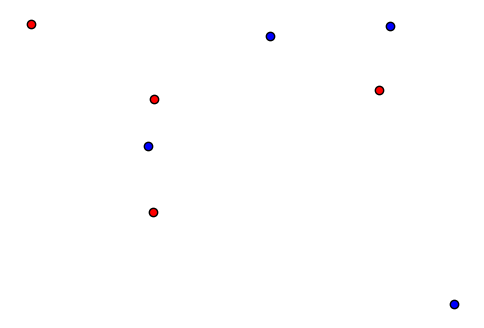

In [30]:
plot_geographic_points(supplier_locations, demander_locations)

#### ANIMATION

Thanks to the following animation we can detect which suppliers satisfy each demand.

In [31]:
animate_supply_demand(points, demand, edges, steps=50)

#### SIMPLEX NETWORK

In this section we explain how the Simplex Method works using the Graph $S(P)$ associated to the problem.

Since a graph with k nodes and no cycles cannot have more than k − 1 edges:

We conclude S(P) cannot have more than n + m − 1 edges, and P cannot have more than n + m − 1 nonzero entries.

In [32]:
non_zero_entries = np.count_nonzero(P)

n_plus_m_minus_1 = len(a) + len(b) - 1

if non_zero_entries <= n_plus_m_minus_1:
    print("The number of non-zero entries in P⋆ is less or equal to n+m-1.")
    
else:
    print("The number of non-zero entries in P⋆ is not less or equal to n+m-1.")

The number of non-zero entries in P⋆ is less or equal to n+m-1.


this condition is satisfied.

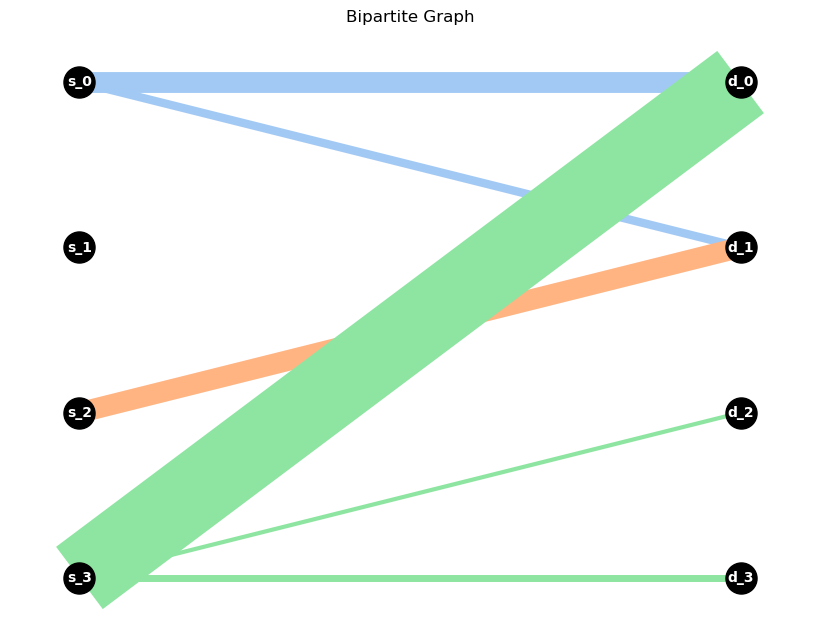

In [33]:
# SIMPLEX NETWORK

G = nx.Graph()

for i in range(len(a)):
    G.add_node(f's_{i}', pos=(0, i), color='red')

for j in range(len(b)):
    G.add_node(f'd_{j}', pos=(1, j), color='blue')

group_colors = {}

for i, j in edges:
    supply_node = f's_{i}'
    demand_node = f'd_{j}'
    
    if supply_node not in group_colors:

        group_colors[supply_node] = len(group_colors)
    
    edge_color = group_colors[supply_node]
    
    G.add_edge(supply_node, demand_node, weight=P[i, j], color=edge_color)

pos = nx.get_node_attributes(G, 'pos')
colors = nx.get_node_attributes(G, 'color')
weights = nx.get_edge_attributes(G, 'weight')
edge_colors = nx.get_edge_attributes(G, 'color')

edge_palette = plt.cm.get_cmap('Set3', len(group_colors))

edge_palette = sns.color_palette("pastel", len(group_colors))

pos = {node: (pos[node][0], len(b) - pos[node][1]) for node in pos}

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='black', font_color='white', font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=list(weights.values()), edge_color=[edge_palette[c] for c in edge_colors.values()])
plt.title('Bipartite Graph')
plt.axis('off')
plt.show()

This graph shows the mass splitting phenomena among the consumers.

Moreover, the following graph represent one step in the simplex method:

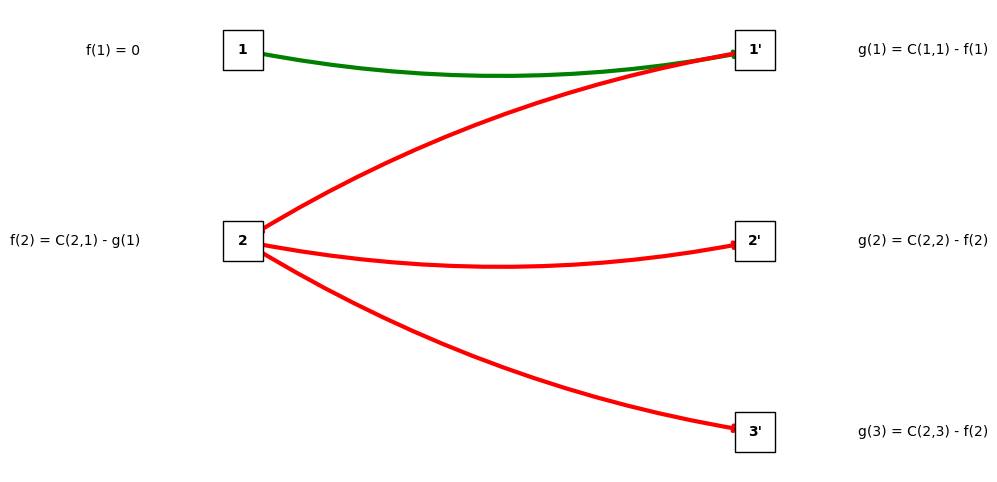

In [34]:
# EXAMPLE of Assignment for Netowrk Simplex

G = nx.DiGraph()

node_labels = {

    '1': 'f(1) = 0',
    "1'": 'g(1) = C(1,1) - f(1)',
    '2': 'f(2) = C(2,1) - g(1)',
    "2'": 'g(2) = C(2,2) - f(2)',
    "3'": 'g(3) = C(2,3) - f(2)'
}

vertical_spacing = 0.5

for node, label in node_labels.items():

    x = 0.5 if '\'' in node else 0 

    y = vertical_spacing * (2 - int(node[0]) if node[0].isdigit() else 2 - int(node[0][0]))  

    G.add_node(node, pos=(x, y), internal_label=node, external_label=label)

edges_with_colors = [
    
    ('1', "1'", 'green'),
    ("1'", '2', 'red'),
    ('2', "2'", 'red'),
    ('2', "3'", 'red')
]

for u, v, color in edges_with_colors:
    G.add_edge(u, v, color=color)

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(8, 6))

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='white', edgecolors='black', node_shape='s')

internal_labels = {node: data['internal_label'] for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=internal_labels, font_size=10, font_weight='bold')

for node, data in G.nodes(data=True):
    
    node_pos = pos[node]
    label = data['external_label']

    if "'" in node:  
        label_pos = (node_pos[0] + 0.1, node_pos[1])
        ha = 'left'
    else:  
        label_pos = (node_pos[0] - 0.1, node_pos[1])
        ha = 'right'

    plt.text(label_pos[0], label_pos[1], label, fontsize=10, verticalalignment='center', horizontalalignment=ha)

edges = G.edges()
colors = [G[u][v]['color'] for u, v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=3, connectionstyle='arc3,rad=0.1')

plt.axis('off')

plt.margins(0.05)

plt.show()


#### GLOBAL MARKET

In this section we present a possible application of Simplex Algorithm to solve an instance of (OT) problem, considering the global market of a precise good.

In [35]:
dataset_path = '/Users/matteocasiraghi/Desktop/THESIS/world_country_latitude_and_longitude_values.csv'

df = pd.read_csv(dataset_path, sep=';')

In [36]:
df #database with country locations

country_code   latitude  longitude               country
0             AD  42.546245   1.601554               Andorra
1             AE  23.424076  53.847818  United Arab Emirates
2             AF  33.939110  67.709953           Afghanistan
3             AG  17.060816 -61.796428   Antigua and Barbuda
4             AI  18.220554 -63.068615              Anguilla
..           ...        ...        ...                   ...
240           YE  15.552727  48.516388                 Yemen
241           YT -12.827500  45.166244               Mayotte
242           ZA -30.559482  22.937506          South Africa
243           ZM -13.133897  27.849332                Zambia
244           ZW -19.015438  29.154857              Zimbabwe

[245 rows x 4 columns]

In [37]:
df = df.dropna(subset=['latitude'])

In [38]:
locations = df[['latitude', 'longitude']].values # Extract the latitude and longitude into an array

In [39]:
locations

array([[ 4.25462450e+01,  1.60155400e+00],
       [ 2.34240760e+01,  5.38478180e+01],
       [ 3.39391100e+01,  6.77099530e+01],
       [ 1.70608160e+01, -6.17964280e+01],
       [ 1.82205540e+01, -6.30686150e+01],
       [ 4.11533320e+01,  2.01683310e+01],
       [ 4.00690990e+01,  4.50381890e+01],
       [ 1.22260790e+01, -6.90600870e+01],
       [-1.12026920e+01,  1.78738870e+01],
       [-7.52509730e+01, -7.13890000e-02],
       [-3.84160970e+01, -6.36166720e+01],
       [-1.42709720e+01, -1.70132217e+02],
       [ 4.75162310e+01,  1.45500720e+01],
       [-2.52743980e+01,  1.33775136e+02],
       [ 1.25211100e+01, -6.99683380e+01],
       [ 4.01431050e+01,  4.75769270e+01],
       [ 4.39158860e+01,  1.76790760e+01],
       [ 1.31938870e+01, -5.95431980e+01],
       [ 2.36849940e+01,  9.03563310e+01],
       [ 5.05038870e+01,  4.46993600e+00],
       [ 1.22383330e+01, -1.56159300e+00],
       [ 4.27338830e+01,  2.54858300e+01],
       [ 2.59304140e+01,  5.06377720e+01],
       [-3.

In [40]:
df = df.drop('country_code', axis=1)

In [41]:
df['market'] = np.random.choice([0, 1], size=len(df)) # Add 'market' column with random 1 = (supply) and 0 = (demand)

In [42]:
df

latitude  longitude               country  market
0    42.546245   1.601554               Andorra       0
1    23.424076  53.847818  United Arab Emirates       0
2    33.939110  67.709953           Afghanistan       1
3    17.060816 -61.796428   Antigua and Barbuda       0
4    18.220554 -63.068615              Anguilla       0
..         ...        ...                   ...     ...
240  15.552727  48.516388                 Yemen       1
241 -12.827500  45.166244               Mayotte       0
242 -30.559482  22.937506          South Africa       1
243 -13.133897  27.849332                Zambia       0
244 -19.015438  29.154857              Zimbabwe       1

[244 rows x 4 columns]

In [43]:
def generate_supply_demand_quantities(df, goods):
    """Function to generate the goods for an hypothetical global market"""
   
    num_suppliers = df[df['market'] == 1].shape[0]
    num_consumers = df[df['market'] == 0].shape[0]

    supply_quantities = np.random.multinomial(goods, np.random.dirichlet(np.ones(num_suppliers) * 0.9))
    demand_quantities = np.random.multinomial(goods, np.random.dirichlet(np.ones(num_consumers) * 0.9))

    df['goods'] = 0
    
    df.loc[df['market'] == 1, 'goods'] = supply_quantities  
    df.loc[df['market'] == 0, 'goods'] = demand_quantities  

    return df

In [44]:
df = generate_supply_demand_quantities(df, 1000)

In [45]:
df

latitude  longitude               country  market  goods
0    42.546245   1.601554               Andorra       0      3
1    23.424076  53.847818  United Arab Emirates       0      1
2    33.939110  67.709953           Afghanistan       1      7
3    17.060816 -61.796428   Antigua and Barbuda       0      6
4    18.220554 -63.068615              Anguilla       0      4
..         ...        ...                   ...     ...    ...
240  15.552727  48.516388                 Yemen       1      0
241 -12.827500  45.166244               Mayotte       0     15
242 -30.559482  22.937506          South Africa       1      2
243 -13.133897  27.849332                Zambia       0     13
244 -19.015438  29.154857              Zimbabwe       1      1

[244 rows x 5 columns]

We extract just those countries that partecipate in the market:

In [46]:
# filter only entries with demand in the market column

demanders = df[df['market'] == 0].reset_index(drop=True)
demanders = demanders.drop('market', axis=1)

In [47]:
zero_demanders = demanders[demanders['goods'] == 0]
demanders = demanders.drop(zero_demanders.index).reset_index(drop=True)

In [48]:
demanders

latitude   longitude               country  goods
0    42.546245    1.601554               Andorra      3
1    23.424076   53.847818  United Arab Emirates      1
2    17.060816  -61.796428   Antigua and Barbuda      6
3    18.220554  -63.068615              Anguilla      4
4    41.153332   20.168331               Albania     14
..         ...         ...                   ...    ...
96   14.058324  108.277199               Vietnam      6
97  -15.376706  166.959158               Vanuatu      9
98  -13.768752 -177.156097     Wallis and Futuna     15
99  -12.827500   45.166244               Mayotte     15
100 -13.133897   27.849332                Zambia     13

[101 rows x 4 columns]

In [49]:
demander_locations_g = demanders[['latitude', 'longitude']].values

In [50]:
print(demander_locations_g)

[[  42.546245    1.601554]
 [  23.424076   53.847818]
 [  17.060816  -61.796428]
 [  18.220554  -63.068615]
 [  41.153332   20.168331]
 [ -38.416097  -63.616672]
 [  12.52111   -69.968338]
 [  43.915886   17.679076]
 [  12.238333   -1.561593]
 [   9.30769     2.315834]
 [  32.321384  -64.75737 ]
 [ -16.290154  -63.588653]
 [  25.03428   -77.39628 ]
 [  27.514162   90.433601]
 [  -4.038333   21.758664]
 [   6.611111   20.939444]
 [  46.818188    8.227512]
 [   7.539989   -5.54708 ]
 [  35.86166   104.195397]
 [   9.748917  -83.753428]
 [  21.521757  -77.781167]
 [  51.165691   10.451526]
 [  11.825138   42.590275]
 [  56.26392     9.501785]
 [  15.414999  -61.370976]
 [  28.033886    1.659626]
 [  -1.831239  -78.183406]
 [  26.820553   30.802498]
 [  61.92411    25.748151]
 [  46.227638    2.213749]
 [  -0.803689   11.609444]
 [  12.262776  -61.604171]
 [  42.315407   43.356892]
 [   7.946527   -1.023194]
 [  71.706936  -42.604303]
 [  16.995971  -62.067641]
 [  39.074208   21.824312]
 

In [51]:
# filter only entries with supply in the market column

suppliers = df[df['market'] == 1].reset_index(drop=True)
suppliers = suppliers.drop('market', axis=1)

In [52]:
zero_suppliers = suppliers[suppliers['goods'] == 0]
suppliers = suppliers.drop(zero_suppliers.index).reset_index(drop=True)

In [53]:
suppliers

latitude   longitude               country  goods
0    33.939110   67.709953           Afghanistan      7
1    40.069099   45.038189               Armenia      2
2    12.226079  -69.060087  Netherlands Antilles      3
3   -11.202692   17.873887                Angola     39
4   -75.250973   -0.071389            Antarctica     20
..         ...         ...                   ...    ...
108  41.902916   12.453389          Vatican City     16
109  18.335765  -64.896335   U.S. Virgin Islands      3
110 -13.759029 -172.104629                 Samoa     11
111 -30.559482   22.937506          South Africa      2
112 -19.015438   29.154857              Zimbabwe      1

[113 rows x 4 columns]

In [54]:
supplier_locations_g = suppliers[['latitude', 'longitude']].values

In [55]:
print(supplier_locations_g)

[[ 3.39391100e+01  6.77099530e+01]
 [ 4.00690990e+01  4.50381890e+01]
 [ 1.22260790e+01 -6.90600870e+01]
 [-1.12026920e+01  1.78738870e+01]
 [-7.52509730e+01 -7.13890000e-02]
 [-1.42709720e+01 -1.70132217e+02]
 [ 4.75162310e+01  1.45500720e+01]
 [-2.52743980e+01  1.33775136e+02]
 [ 4.01431050e+01  4.75769270e+01]
 [ 1.31938870e+01 -5.95431980e+01]
 [ 2.36849940e+01  9.03563310e+01]
 [ 5.05038870e+01  4.46993600e+00]
 [ 2.59304140e+01  5.06377720e+01]
 [-3.37305600e+00  2.99188860e+01]
 [ 4.53527700e+00  1.14727669e+02]
 [-1.42350040e+01 -5.19252800e+01]
 [-2.23284740e+01  2.46848660e+01]
 [ 5.37098070e+01  2.79533890e+01]
 [ 1.71898770e+01 -8.84976500e+01]
 [-1.21641650e+01  9.68709560e+01]
 [-2.28021000e-01  1.58276590e+01]
 [-3.56751470e+01 -7.15429690e+01]
 [ 7.36972200e+00  1.23547220e+01]
 [ 4.57086800e+00 -7.42973330e+01]
 [ 1.60020820e+01 -2.40131970e+01]
 [-1.04475250e+01  1.05690449e+02]
 [ 3.51264130e+01  3.34298590e+01]
 [ 1.87356930e+01 -7.01626510e+01]
 [ 5.85952720e+01  2

We show the variables describing the Global Market:

In [56]:
a_g = np.array(suppliers['goods']) 

In [57]:
a_g # supply vector

array([ 7,  2,  3, 39, 20,  5,  2,  4,  2,  4, 12, 14, 10,  1,  2,  3,  3,
        2,  3,  1,  9,  5,  2, 23,  7, 19, 15, 10,  2,  6,  2, 19,  1,  9,
       17, 16, 13,  6,  2, 12,  7, 16, 10, 27,  3,  8, 12,  8,  8, 15, 14,
        1,  5, 44,  8,  6,  6,  1,  4,  7, 13,  1,  3,  1,  9,  3,  2,  7,
        1,  3,  1, 24, 23,  5,  6,  4, 41,  2, 10, 11, 10, 38,  3,  1, 12,
        2,  5,  3,  6,  8,  7, 24, 17,  3, 16, 15,  6,  5,  1,  9,  9,  1,
        7, 26,  4,  3,  7,  5, 16,  3, 11,  2,  1])

In [58]:
b_g = np.array(demanders['goods'])

In [59]:
b_g # demand vector

array([ 3,  1,  6,  4, 14,  6,  4, 19, 11,  1, 17,  8, 15, 15,  4,  7,  3,
       17,  5, 18, 13, 18,  2, 19,  1,  4,  1, 10,  3,  9,  6, 10,  7, 14,
       10, 14,  5, 30,  1,  2,  4, 11, 13,  4,  9,  1,  1, 36,  4, 13,  6,
       35,  9,  3,  7, 12,  5,  3, 14, 13,  4,  3,  2, 30, 40,  5,  2,  6,
       20, 14,  8, 11,  2, 16,  7, 18,  2, 17, 52, 30,  1, 13,  5,  2,  8,
        5,  1, 13, 19,  3,  7,  2,  2,  2,  9,  1,  6,  9, 15, 15, 13])

In [60]:
C_g = np.random.randint(1, 100, size=(len(a_g), len(b_g)))    

In [61]:
C_g # Cost Matrix

array([[69, 52, 37, ..., 50, 59,  4],
       [24,  9, 88, ..., 85, 83, 24],
       [17, 26, 12, ..., 67,  5, 12],
       ...,
       [59, 16, 19, ..., 92,  2, 83],
       [18, 88, 39, ..., 61,  4, 72],
       [26, 52, 32, ..., 93, 66, 52]])

In [62]:
P_g, sol_g = simplex(C_g, a_g, b_g)

In [63]:
P_g # Optimal Transport Plan

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 7., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
sol_g # Minimal cost of transportation

3596.0

In [65]:
demands_satisfied = check_demands_satisfied(P_g, b_g)
print("Are all demands satisfied?", demands_satisfied)

Are all demands satisfied? True


In [66]:
edges_g = extract_edges(P_g)

In [67]:
edges_g

[(0, 79),
 (1, 81),
 (2, 81),
 (3, 10),
 (3, 27),
 (3, 33),
 (3, 40),
 (3, 55),
 (3, 57),
 (4, 58),
 (4, 59),
 (4, 77),
 (5, 99),
 (6, 41),
 (7, 42),
 (8, 90),
 (9, 37),
 (10, 37),
 (10, 38),
 (10, 97),
 (11, 78),
 (12, 51),
 (13, 73),
 (14, 33),
 (15, 19),
 (16, 60),
 (17, 74),
 (18, 7),
 (18, 29),
 (19, 77),
 (20, 35),
 (20, 36),
 (21, 34),
 (21, 45),
 (21, 74),
 (22, 64),
 (23, 49),
 (23, 65),
 (23, 86),
 (23, 94),
 (24, 31),
 (24, 96),
 (25, 34),
 (25, 43),
 (25, 84),
 (26, 7),
 (26, 35),
 (26, 56),
 (27, 68),
 (28, 53),
 (29, 6),
 (29, 72),
 (30, 65),
 (31, 41),
 (31, 100),
 (32, 64),
 (33, 3),
 (33, 20),
 (33, 48),
 (33, 78),
 (34, 8),
 (34, 63),
 (35, 23),
 (35, 30),
 (36, 73),
 (37, 51),
 (38, 35),
 (39, 5),
 (39, 9),
 (39, 67),
 (39, 95),
 (40, 8),
 (40, 76),
 (41, 19),
 (41, 65),
 (42, 78),
 (43, 18),
 (43, 20),
 (43, 52),
 (43, 79),
 (44, 99),
 (45, 29),
 (45, 68),
 (46, 12),
 (46, 30),
 (47, 69),
 (48, 78),
 (49, 25),
 (49, 56),
 (49, 88),
 (50, 4),
 (51, 79),
 (52, 49),
 (

In [68]:
points_g = generate_points(edges_g, supplier_locations_g)

In [69]:
demand_g = generate_demand_points(demander_locations_g, b_g)

In [70]:
animate_supply_demand(points_g, demand_g, edges_g, steps=100)

#### TIME COMPLEXITY

In this section we analyze the time complexity of the Simplex algorithm in function of the number of suppliers/consumers.

In [95]:
def run_optimal_transport(n):
    """Function to run the optimal transport problem with a given number of locations"""

    C, a, b = generate_random_OT_problem(n, n, n * 50)

    start_time = time.time()

    transport_matrix , objective = simplex(C, a, b)

    end_time = time.time()

    elapsed_time = end_time - start_time

    print("Optimal Transport Matrix:\n\n", transport_matrix)
    print("\nobjective:\n\n", objective)
    print(f"\ntime with {n}:\n\n", elapsed_time)

    return transport_matrix, objective, elapsed_time 

In [96]:
results_array = run_optimal_transport(50)

Optimal Transport Matrix:

 [[ 0.  0.  0. ...  0.  0.  0.]
 [28.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0. 16.  0. ... 63.  0.  0.]]

objective:

 128.14472330955292

time with 50:

 0.03103804588317871


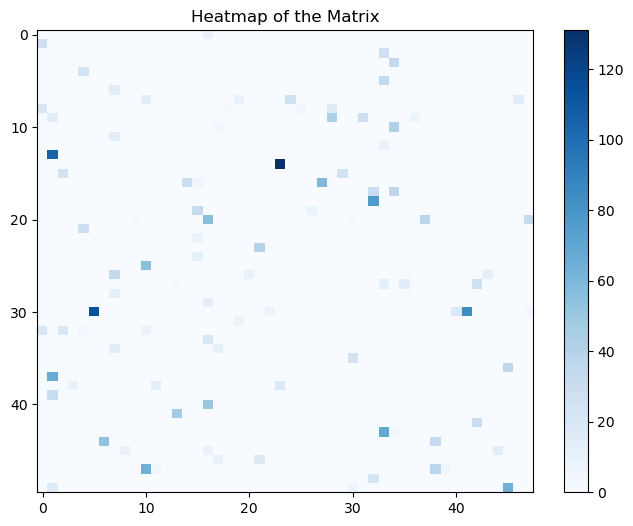

In [97]:
plot_heatmap(results_array[0])

In [98]:
results_array = run_optimal_transport(100)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 189.80274785145295

time with 100:

 0.17541193962097168


In [99]:
results_array = run_optimal_transport(150)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 154.95560410828466

time with 150:

 0.8699121475219727


In [100]:
results_array = run_optimal_transport(200)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 155.2705683893993

time with 200:

 4.025822877883911


In [101]:
results_array = run_optimal_transport(250)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 157.08082385365515

time with 250:

 5.665847063064575


In [102]:
results_array = run_optimal_transport(300)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 174.40850501766877

time with 300:

 15.835306882858276


In [103]:
results_array = run_optimal_transport(350)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 171.61632613561986

time with 350:

 18.941927909851074


In [104]:
results_array = run_optimal_transport(400)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 160.76821773716773

time with 400:

 31.047266006469727


In [105]:
results_array = run_optimal_transport(450)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 162.76254972994002

time with 450:

 85.59822487831116


In [106]:
results_array = run_optimal_transport(500)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 189.32749988981942

time with 500:

 100.66599893569946


In [107]:
results_array = run_optimal_transport(550)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 202.04283431473704

time with 550:

 188.96694993972778


In [110]:
results_array = run_optimal_transport(600)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 159.72663761823085

time with 600:

 213.35768175125122


In [111]:
results_array = run_optimal_transport(650)

Optimal Transport Matrix:

 [[ 0. 73.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

objective:

 168.49590004232223

time with 650:

 307.7742660045624


In [112]:
results_array = run_optimal_transport(700)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 168.91899096112564

time with 700:

 1228.2650771141052


In [113]:
results_array = run_optimal_transport(750)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 176.73600171545831

time with 750:

 4268.651992797852


In [263]:
# example of collected results through simulations

results_array_tot = [
[  50, 0.030359745025634766],
[  100, 0.1548900604248047],
[  150, 0.47479820251464844],
[  200, 1.0916409492492676],
[  250, 4.936448097229004],
[  300, 6.9135308265686035],
[  350, 18.302703857421875],
[  400, 29.53562903404236],
[  450, 66.12695670127869],
[  500, 133.10923790931702],
[  550, 146.45177388191223],
[  600, 247.0400230884552],
[  650, 482.8315498828888],
[  700, 520.7028739452362],
[  750, 603.314416885376]]

In [281]:
tuples_array = np.array([(x[0], x[1]) for x in results_array_tot])

n_values = tuples_array[:, 0]  
time_values = tuples_array[:, 1]  

We move to a log-scale in order to visualize the correlation between the number of locations and the computational complexity

In [282]:
log_time_values = np.log(time_values)

In [283]:
log_n_values = np.log(n_values)

In [284]:
log_n_values # number of locations

array([3.91202301, 4.60517019, 5.01063529, 5.29831737, 5.52146092,
       5.70378247, 5.85793315, 5.99146455, 6.10924758, 6.2146081 ,
       6.30991828, 6.39692966, 6.47697236, 6.55108034, 6.62007321])

In [285]:
log_time_values # time to solve the problem

array([-3.49463772, -1.8650397 , -0.7448654 ,  0.08768202,  1.59664606,
        1.93348048,  2.9070488 ,  3.3855973 ,  4.19157648,  4.89117013,
        4.98669619,  5.50955036,  6.17966783,  6.25517958,  6.40243848])

We visualize the empirical data collected running the above implemented Simplex Algorithm.

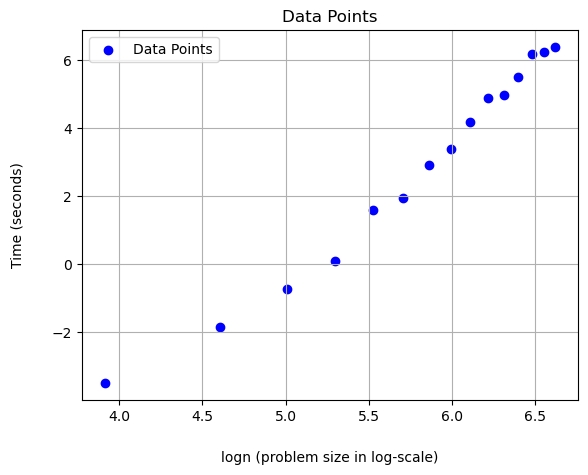

In [345]:
plt.scatter(log_n_values, log_time_values, color='blue', label='Data Points')

plt.xlabel('logn (problem size in log-scale)', labelpad=20)
plt.ylabel('Time (seconds)', labelpad=20)

plt.title('Data Points')

plt.legend()
plt.grid(True)
plt.show()

From the literature the time complexity of the algorithm should be:
$$
O\left( (n+m)nm \log(n+m) \log((n+m) \lVert C \rVert_{\infty}) \right)
$$

For this function we can only compute an average value between those assumed during the iterations. This approximation is probably one of the main point related to the noise in the time complexity curve fitted through empriical data.

In [195]:
def f_simplex(n):
    return n**3 * np.log(2*n) * np.log(2 * n)

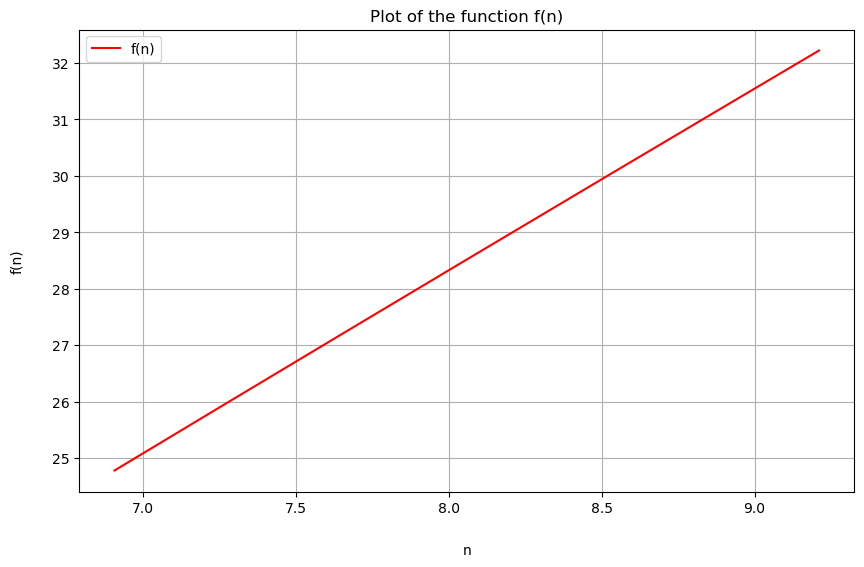

In [344]:
values = np.linspace(1000, 10001, 1000)

f_values = np.log(f_simplex(values))

plt.figure(figsize=(10, 6))

plt.plot(log(values), f_values, label='f(n)', color='red')

plt.xlabel('n', labelpad=20)
plt.ylabel('f(n)', labelpad=20)

plt.title('Plot of the function f(n)')

plt.legend()
plt.grid(True)
plt.show()

In [197]:
def model(n, F, b):
    """Function to fit the time complexity curve in log-scale"""
    
    return F * np.log(f_simplex(n)) + b

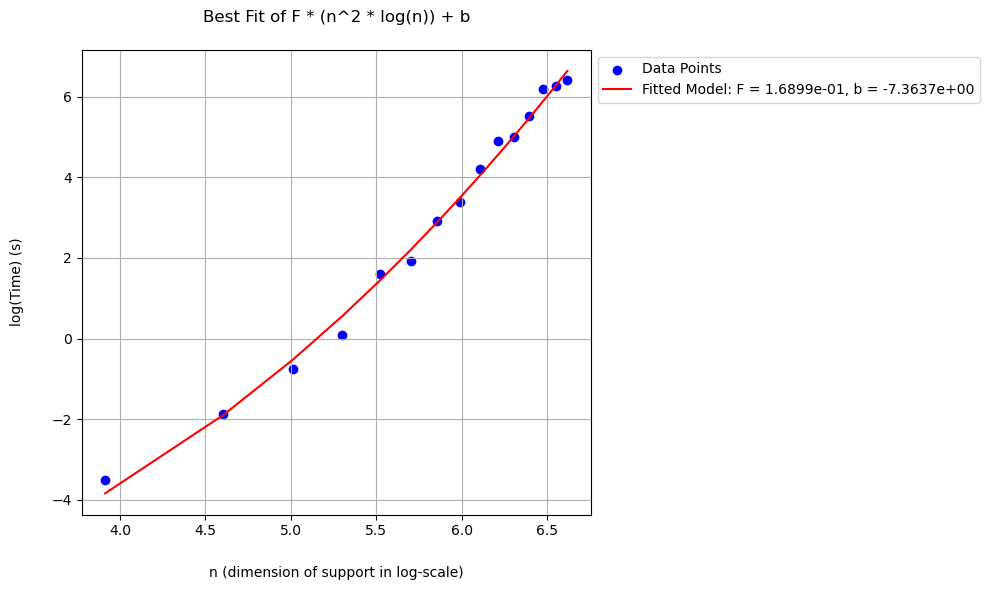

In [290]:
params, covariance = curve_fit(model, log_n_values, log_time_values, p0=[0.0001, 1])

fitted_values = model(log_n_values, *params)

plt.figure(figsize=(10, 6))  

plt.scatter(log_n_values, log_time_values, color='blue', label='Data Points')
plt.plot(log_n_values, fitted_values, color='red', label=f'Fitted Model: F = {params[0]:.4e}, b = {params[1]:.4e}')

plt.xlabel('n (dimension of support in log-scale)', labelpad=20)
plt.ylabel('log(Time) (s)', labelpad=20)

plt.title('Best Fit of F * (n^2 * log(n)) + b', pad=20)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

we imagine the results this algorithm could obtain in practical applications, like for example working in a task of image processing on images 4096x4096:

In [222]:
def model(n, F, b):
    """Function to fit the time complexity curve"""
    
    return F * f_simplex(n) + b

In [223]:
params, covariance = curve_fit(model, n_values, time_values, p0=[1, 0])

fitted_values = model(n_values, *params)

In [224]:
print(f"The best constant F is: {params[0]}")
print(f"The best constant b is: {params[1]}")

The best constant F is: 2.8858314677328867e-08
The best constant b is: -23.79454733521601


In [292]:
n = 4096
F = 2.8858314677328867e-08
b = -23.79454733521601

result = F * n**3 * log(2 * n) * log(2 * n) + b
print("number of hours:", result/(3600))

number of hours: 44.722055243413756


Considering applications in fields like image processing this result is not an acceptable amount of time. 

#### SINKHORN ALGORITHM

In this section we consider a new formulation of the (OT) problem where we consider the task to find the right rescaling vectors to transform a Matrix $K$ representing the Entropy of the system in the final Transport Plan matrix $P$.

$$
P_{i,j} = u_i K_{i,j} v_j
$$

In this new setting we use the Sinkhorn Algorithm to solve it.

In [322]:
def sinkhorn_algorithm(cost_matrix, a, b, reg=0.01, num_iters=500, tol=1e-9):
    """Function to solve the OT problem stated with Rescaling Problem formulation"""
    
    convergence = False

    a_normalized = a / np.sum(a)
    b_normalized = b / np.sum(b)

    K = np.exp(-cost_matrix / reg)
    u = np.ones(len(a))
    v = np.ones(len(b))

    for _ in range(num_iters):
        u = a_normalized / (K @ v)
        v = b_normalized / (K.T @ u)
        
        marginal_error_a = np.linalg.norm(a_normalized - u * (K @ v), 1)
        marginal_error_b = np.linalg.norm(b_normalized - v * (K.T @ u), 1)

        if marginal_error_a + marginal_error_b < tol:
            convergence = True
            break

    P = np.diag(u) @ K @ np.diag(v)
    
    minimal_cost = np.sum(P * cost_matrix)
    
    return P , minimal_cost , convergence

#### TIME COMPLEXITY 

In [323]:
def run_optimal_transport_sink(n):
    """Function to run the Sinkhorn algorithm with a given number of locations"""
    
    C , a , b = generate_random_OT_problem(n, n, n*50, (0,1))

    start_time = time.time()
    P_sinkhorn , obj_sinkhorn , convergence = sinkhorn_algorithm(C, a, b)
    sinkhorn_time = time.time() - start_time

    print("\nSinkhorn Results:")
    print("\nTransport Matrix P (Sinkhorn):\n\n", P_sinkhorn)
    print("\nObjective (Sinkhorn):", obj_sinkhorn)
    print("\nTime (Sinkhorn):", sinkhorn_time)
    print("\nConvergence (Sinkhorn):", convergence)

In [324]:
run_optimal_transport_sink(n=1000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[1.68159999e-32 3.40471137e-40 2.59724604e-31 ... 9.29337315e-36
  5.89898167e-22 3.10389618e-17]
 [3.02455167e-21 3.30356068e-11 1.26803561e-27 ... 3.24442396e-44
  5.34305456e-42 6.07856331e-18]
 [3.48835134e-25 2.90785738e-07 7.92037130e-11 ... 2.31075464e-30
  6.67028068e-15 1.22372788e-30]
 ...
 [2.29445814e-19 2.10010239e-07 5.47979824e-29 ... 1.93957907e-11
  2.97309966e-38 8.25972013e-45]
 [3.20321674e-38 1.63059105e-30 1.07586330e-35 ... 2.82554176e-43
  1.87145129e-33 3.81074216e-26]
 [3.53972543e-15 1.78861314e-15 1.45306217e-20 ... 5.23106712e-08
  3.92798875e-44 1.94002960e-12]]

Objective (Sinkhorn): 0.011309332520540075

Time (Sinkhorn): 0.0482330322265625

Convergence (Sinkhorn): True


In [325]:
run_optimal_transport_sink(n=2000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[2.67885513e-35 2.32873975e-48 1.05030587e-37 ... 5.42541403e-21
  6.74844173e-46 1.20494986e-27]
 [9.33838486e-33 7.92399076e-17 1.30978999e-39 ... 1.67337667e-09
  1.48462996e-07 2.87509447e-42]
 [1.52536948e-35 1.36074058e-46 2.24742593e-43 ... 3.25073938e-25
  1.75780033e-31 1.38903175e-15]
 ...
 [8.23852700e-47 1.45312701e-20 1.98610138e-20 ... 2.60720004e-18
  4.52538104e-32 8.55367198e-25]
 [3.96368737e-41 2.22390739e-43 2.10704448e-32 ... 1.33421043e-36
  3.18809967e-42 1.40675836e-32]
 [9.79259540e-40 1.04461481e-19 5.23055661e-39 ... 5.38939641e-25
  1.91379605e-37 2.04640079e-39]]

Objective (Sinkhorn): 0.010713973680238081

Time (Sinkhorn): 0.2939951419830322

Convergence (Sinkhorn): True


In [326]:
run_optimal_transport_sink(n=3000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[1.24756079e-34 2.62642810e-37 4.94540826e-39 ... 2.86491591e-43
  1.07942147e-29 4.57100536e-10]
 [1.05242428e-42 1.47120461e-28 1.37690512e-24 ... 1.72269641e-16
  5.46763851e-24 3.86792070e-37]
 [1.21830926e-16 1.35602066e-10 1.67753927e-33 ... 1.40907176e-22
  1.35775088e-14 9.02755847e-40]
 ...
 [5.87833871e-21 3.05035959e-08 1.26504847e-24 ... 2.15355620e-32
  6.70421011e-36 3.16027189e-34]
 [2.03870497e-19 1.30588152e-27 5.91072011e-35 ... 8.31384160e-45
  5.99281607e-37 1.99608397e-12]
 [1.06173245e-37 3.20029586e-42 2.53895578e-47 ... 3.44066011e-13
  5.02361270e-11 2.55100668e-23]]

Objective (Sinkhorn): 0.010426528007456025

Time (Sinkhorn): 1.3612000942230225

Convergence (Sinkhorn): True


In [327]:
run_optimal_transport_sink(n=4000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[4.52747590e-16 3.00925807e-28 1.26616069e-42 ... 2.23769827e-18
  4.75680221e-48 6.79036278e-13]
 [1.75233887e-34 2.65210303e-39 2.86271562e-08 ... 1.69294301e-37
  3.31353590e-43 5.31526004e-44]
 [1.50229427e-13 1.26425527e-29 6.95407347e-34 ... 4.15761234e-09
  1.06186653e-47 2.88779823e-30]
 ...
 [2.80183717e-36 7.70684920e-27 4.08845456e-42 ... 5.04565717e-17
  5.11858267e-34 8.28945351e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.88454284e-31 5.90077164e-50 6.81176444e-41 ... 3.52010008e-38
  1.80737833e-18 6.87570846e-42]]

Objective (Sinkhorn): 0.010298871297347491

Time (Sinkhorn): 2.361569881439209

Convergence (Sinkhorn): True


In [328]:
run_optimal_transport_sink(n=5000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[2.41028621e-46 7.09494668e-38 2.46156114e-07 ... 5.65993107e-15
  4.03199964e-09 1.43911968e-10]
 [1.69980372e-38 1.70924317e-07 7.25856040e-16 ... 4.11715757e-44
  8.31993358e-42 7.12234980e-44]
 [4.15357521e-32 1.51350832e-13 2.15220948e-11 ... 4.74790798e-16
  1.19222009e-47 7.72125737e-17]
 ...
 [1.02447960e-07 2.85691564e-42 3.84041867e-26 ... 1.16602976e-34
  6.62200149e-36 7.83058151e-45]
 [3.84373281e-07 5.53713787e-23 3.29947114e-12 ... 2.04686412e-36
  3.49427729e-39 5.88526599e-10]
 [2.26026231e-42 1.89800990e-47 5.41763548e-15 ... 9.61556247e-23
  2.62413798e-18 2.64739122e-45]]

Objective (Sinkhorn): 0.010210595674054872

Time (Sinkhorn): 4.036981105804443

Convergence (Sinkhorn): True


In [329]:
run_optimal_transport_sink(n=6000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[5.41992686e-08 5.40150629e-46 2.86235381e-35 ... 2.48016847e-08
  1.10209928e-18 7.75671134e-34]
 [8.58467108e-41 4.27874320e-14 3.40861934e-08 ... 3.14435689e-14
  2.17631225e-08 4.43665247e-44]
 [1.43052317e-38 3.17779688e-23 5.95881410e-07 ... 8.67075660e-34
  1.76225199e-32 4.44865471e-25]
 ...
 [2.69924361e-25 7.17500816e-11 1.63063684e-19 ... 1.86706453e-35
  7.58013393e-12 9.51556181e-35]
 [7.50646917e-36 1.03626404e-45 2.71037219e-22 ... 1.64532285e-21
  1.17083118e-46 5.84799979e-36]
 [5.17155259e-40 1.80464620e-07 7.63972996e-42 ... 2.27984284e-13
  3.94948766e-45 9.27224264e-31]]

Objective (Sinkhorn): 0.010177244667143428

Time (Sinkhorn): 6.140260934829712

Convergence (Sinkhorn): True


In [330]:
run_optimal_transport_sink(n=7000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[4.60877911e-21 5.09457967e-41 1.31154598e-32 ... 2.22524489e-34
  2.61530435e-15 1.05396057e-38]
 [7.68918246e-46 3.05537489e-08 3.03571676e-43 ... 1.47621060e-09
  3.62587981e-29 6.96284662e-25]
 [2.52654520e-48 6.17555088e-30 6.05009931e-21 ... 8.50692061e-31
  1.36289278e-21 5.85981733e-39]
 ...
 [6.37770642e-49 3.81739936e-11 3.61354070e-25 ... 2.38063801e-16
  6.13069322e-35 1.10001520e-41]
 [5.93391506e-19 2.34684715e-07 1.79599018e-48 ... 2.76619113e-25
  2.41022514e-09 2.01438189e-08]
 [7.30897498e-34 1.24484677e-15 9.33635704e-44 ... 2.27335227e-36
  4.00410576e-51 1.43985753e-50]]

Objective (Sinkhorn): 0.01016863343161379

Time (Sinkhorn): 7.92083477973938

Convergence (Sinkhorn): True


In [331]:
run_optimal_transport_sink(n=8000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[3.37105459e-49 3.71366077e-34 4.69877754e-11 ... 3.32492252e-16
  2.81845574e-34 3.22880103e-13]
 [1.45077127e-21 1.47306391e-15 4.80293719e-09 ... 3.33794612e-48
  1.76992856e-46 1.21716619e-32]
 [6.22562520e-47 4.91602875e-48 1.50406418e-32 ... 4.45127434e-34
  6.65678845e-24 5.62783916e-36]
 ...
 [4.02371740e-41 1.19415020e-39 3.89151995e-26 ... 7.50721245e-23
  6.71234091e-34 2.51988728e-41]
 [2.18682403e-31 8.96261745e-22 2.42817562e-18 ... 7.21839675e-16
  9.29913760e-19 5.75453473e-50]
 [6.24333417e-41 3.28921076e-34 6.29836989e-47 ... 3.84271907e-24
  1.48548837e-18 1.61334496e-24]]

Objective (Sinkhorn): 0.010117977063189388

Time (Sinkhorn): 13.099141120910645

Convergence (Sinkhorn): True


In [332]:
run_optimal_transport_sink(n=9000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[2.02280312e-37 2.08238696e-19 1.55550482e-13 ... 2.33050834e-09
  1.22215730e-32 1.77939639e-25]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04458435e-26 3.98257068e-36 3.79420650e-18 ... 6.66801588e-22
  9.98534401e-45 5.57662969e-15]
 ...
 [1.33030368e-28 7.93705140e-50 2.46468974e-08 ... 2.10105278e-50
  5.48271153e-21 2.27198977e-09]
 [5.03978081e-34 1.09225412e-38 3.34675652e-49 ... 2.93136469e-42
  1.50974614e-25 9.28971176e-25]
 [3.41149538e-33 8.38581900e-22 1.23314959e-22 ... 2.88711011e-25
  3.44954425e-48 3.33514586e-20]]

Objective (Sinkhorn): 0.010111220201785998

Time (Sinkhorn): 14.972187995910645

Convergence (Sinkhorn): True


In [333]:
run_optimal_transport_sink(n=10000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[7.09008108e-13 4.48189773e-31 1.65970867e-17 ... 4.10051975e-21
  3.65599025e-25 1.53876836e-22]
 [1.10979955e-26 1.10912572e-42 1.48517728e-22 ... 3.24859214e-22
  2.27232241e-26 4.53578490e-24]
 [4.99394533e-48 4.77289254e-38 1.19316096e-50 ... 3.45248198e-29
  3.55675539e-31 2.29993892e-28]
 ...
 [3.47591152e-41 5.18792844e-18 9.30425781e-48 ... 1.56936503e-22
  8.75671863e-24 2.23475040e-46]
 [1.05551647e-33 2.09990935e-39 6.12428409e-31 ... 2.13139507e-41
  1.43535857e-09 1.41814693e-42]
 [2.18164676e-42 6.40388282e-43 2.85538447e-21 ... 5.02069208e-45
  1.62731086e-36 3.56568224e-50]]

Objective (Sinkhorn): 0.010104129586202258

Time (Sinkhorn): 21.04201889038086

Convergence (Sinkhorn): True


In [354]:
results_array_tot_sink = [
[1000, 0.24663996696472168],
[2000, 2.0262560844421387],
[3000, 5.033452987670898],
[4000, 9.283386945724487],
[5000, 16.500643253326416],
[6000, 22.918286085128784],
[7000, 33.4692108631134],
[8000, 46.11449718475342],
[9000, 56.875588178634644],
[10000, 72.99319100379944]]

In [355]:
tuples_array_sink = np.array([(x[0], x[1]) for x in results_array_tot_sink])

n_values_sink = tuples_array_sink[:, 0]  
time_values_sink = tuples_array_sink[:, 1]  

In [356]:
log_n_values_sink = np.log(n_values_sink)

In [357]:
log_time_values_sink = np.log(time_values_sink) 

In [358]:
plt.scatter(log_n_values_sink, log_time_values_sink, color='blue', label='Data Points')

plt.xlabel('logn (problem size in log-scale)', labelpad=20)
plt.ylabel('Time in log-scale', labelpad=20)

plt.title('Data Points')

plt.legend()
plt.grid(True)
plt.show()

From the literature the time complexity of the algorithm ( with parameters fixed in order to obtain an error below $\tau$ = 10^-9 ) should be:
$$
O\left( n^2 * log(n) * \tau^{-3} \right)
$$

In [359]:
def f_sinkhorn(n):
    return (n**2 * log(n))

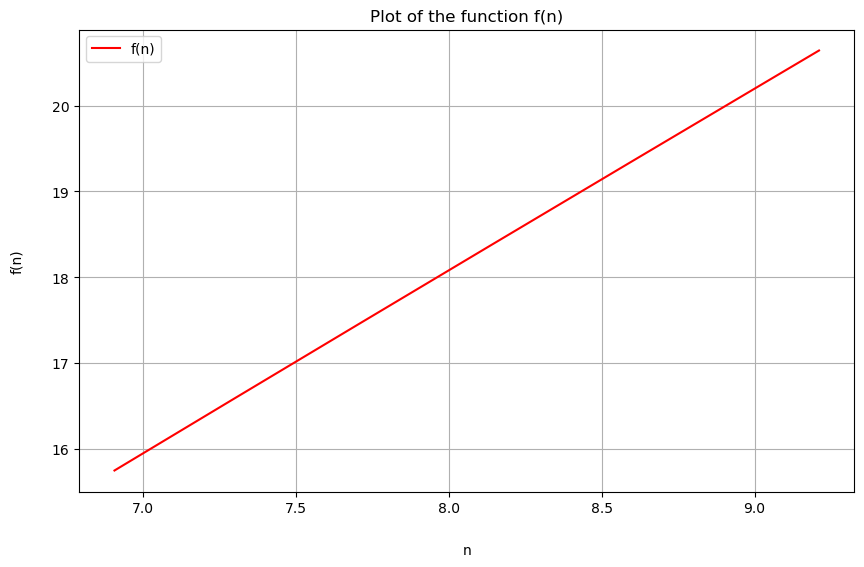

In [360]:
values = np.linspace(1000, 10001, 1000)

f_values = np.log(f_sinkhorn(values))

plt.figure(figsize=(10, 6))

plt.plot(log(values), f_values, label='f(n)', color='red')

plt.xlabel('n', labelpad=20)
plt.ylabel('f(n)', labelpad=20)

plt.title('Plot of the function f(n)')

plt.legend()
plt.grid(True)
plt.show()

In [362]:
def model(n, F, b):
    """Function to fit the time complexity curve in log-scale"""
    
    return F * np.log(f_sinkhorn(n)) + b

In [365]:
params, covariance = curve_fit(model, log_n_values_sink, log_time_values_sink, p0=[0.0001, 1])

fitted_values = model(log_n_values_sink, *params)

plt.figure(figsize=(10, 6))  

plt.scatter(log_n_values_sink, log_time_values_sink, color='blue', label='Data Points')
plt.plot(log_n_values_sink, fitted_values, color='red', label=f'Fitted Model: F = {params[0]:.4e}, b = {params[1]:.4e}')

plt.xlabel('n (dimension of support in log-scale)', labelpad=20)
plt.ylabel('log(Time) (s)', labelpad=20)

plt.title('Best Fit of F * (n^2 * log(n)) + b', pad=20)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

we imagine the results this algorithm could obtain in practical applications, like for example working in a task of image processing on images 4096x4096:

In [289]:
def model(n, F, b):
    """Function to fit the time complexity curve"""
    
    return F * f_sinkhorn(n) + b

In [240]:
params, covariance = curve_fit(model, n_values_sink, time_values_sink, p0=[1, 0])

fitted_values = model(n_values_sink, *params)

In [241]:
print(f"The best constant F is: {params[0]}")
print(f"The best constant b is: {params[1]}")

The best constant F is: 7.946636686446313e-08
The best constant b is: -0.7564100787531828


In [242]:
n = 4096
F = 7.946636686446313e-08
b = -0.7564100787531828

result = F * n**2 * log(n)
print("number of seconds:", result)

number of seconds: 11.08944882044231


#### COMPARISON IN TIME COMPLEXITY

In this section we compare the time compexity curves of the two algorithms in order to show the relevant velocity of the Sinkhorn with respect to the SImplex algorithm.

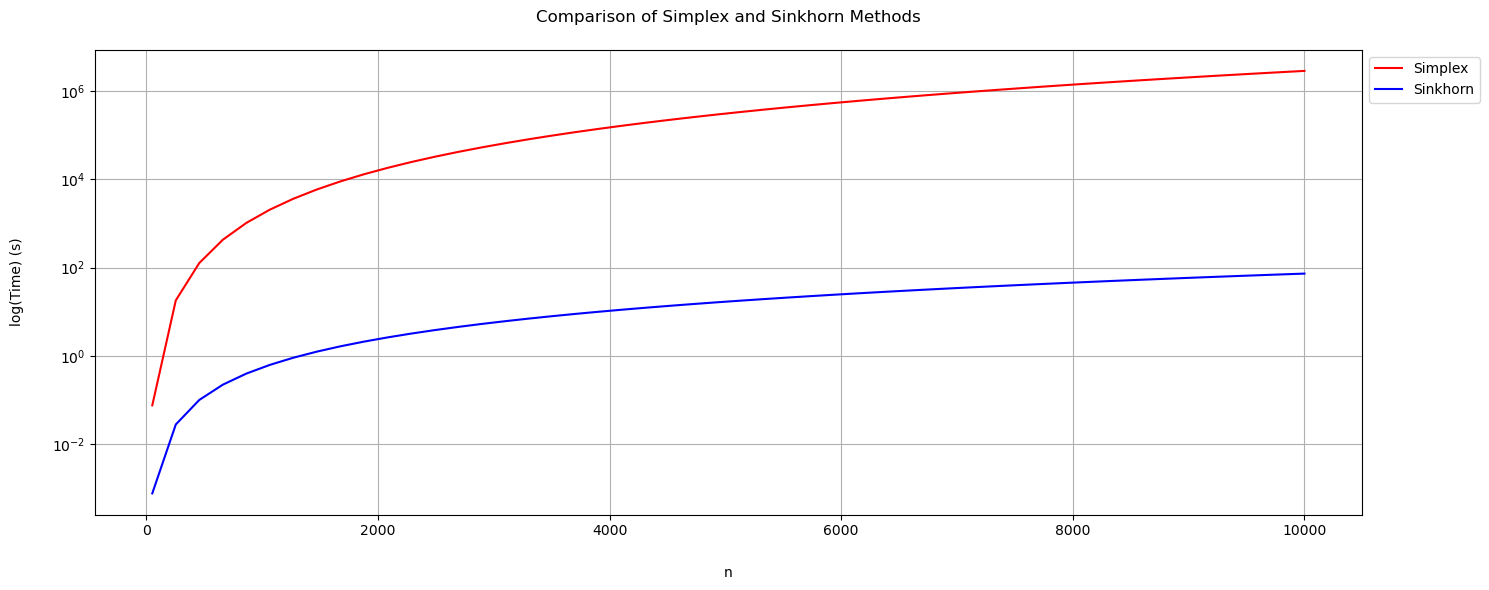

In [349]:
values = np.linspace(50, 10001, 50)

F1 = 2.8858314677328867e-08
F2 = 7.946636686446313e-08

def f1(n):
    return F1 * f_simplex(n)

def f2(n):
    return F2 * f_sinkhorn(n)

f1_values = f1(values)
f2_values = f2(values)

plt.figure(figsize=(15, 6))
plt.plot(values, f1_values, label='Simplex', color='red')
plt.plot(values, f2_values, label='Sinkhorn', color='blue')

plt.xlabel('n', labelpad=20)
plt.ylabel('log(Time) (s)', labelpad=20)

plt.yscale('log')

plt.title('Comparison of Simplex and Sinkhorn Methods', pad=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

#### ANALYSIS IN FUNCTION OF EPSILON $\epsilon$ REGULARIZATION PARAMETER

In this section we analyze how the convergence of the algorithm toward the optimal solution changes in function of the regularization parameter epsilon that defines how much the Sinkhorn algorithm push to solve the original problem, or to maximize entropy.

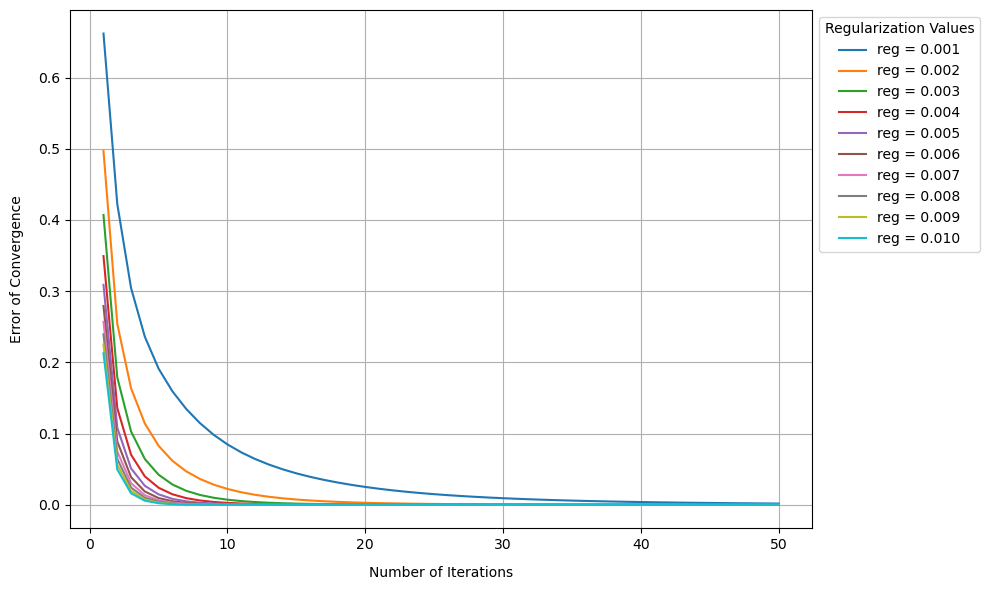

In [196]:
C, a, b = generate_random_OT_problem(1000, 1000, 1000*50, (0, 1))

A = np.zeros((51, 11))  

for j in range(1, 11):  
    for i in range(1, 51):  
        _, obj_sinkhorn, error = sinkhorn_algorithm(C, a, b, reg=0.001*j, num_iters=i)
        A[i, j] = error

# Plotting
plt.figure(figsize=(10, 6))
for j in range(1, 11):
    plt.plot(range(1, 51), A[1:51, j], label=f'reg = {0.001 * j:.3f}')

plt.xlabel('Number of Iterations', labelpad=10)  
plt.ylabel('Error of Convergence', labelpad=10)  
plt.legend(title='Regularization Values', loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()


From this plot we can easily notice that as soon as the regularization parameter becomes closer to 0 and therefore the considered problem becomes closer to the original one the Sinkhorn algorithm converges in a larger number of iterations.

altough this fact, for every value of epsilon, 50 iterations seems enough to ensure convergence.

In [282]:
A = []

In [283]:
C , a , b = generate_random_OT_problem(50, 50, 50*50, (0,1))

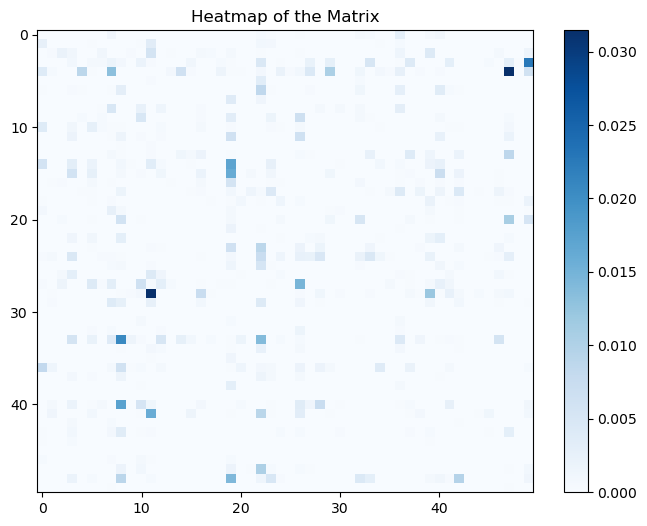

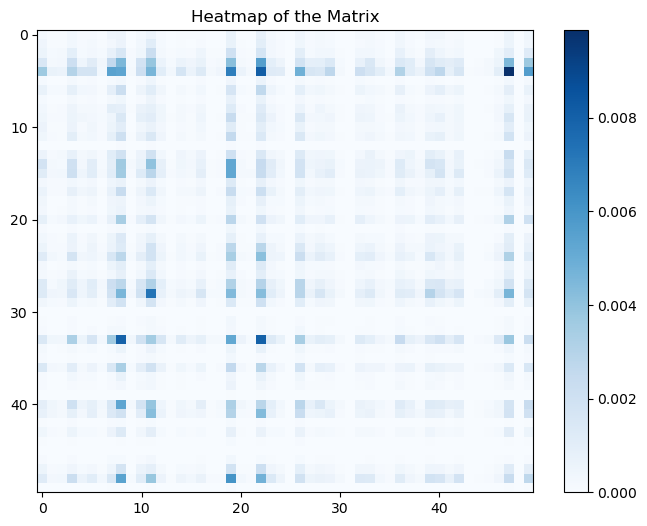

[0.14924257561047358, 0.23660014634493715, 0.3044342250282498, 0.3505505210712302, 0.38222327158751046, 0.4048369646486389, 0.4216249559123463, 0.4345142327073367, 0.44469113236701496, 0.452915221054221]


In [284]:
for i in range(1, 11, 1):
    P_sinkhorn , obj_sinkhorn , convergence = sinkhorn_algorithm(C, a, b, reg=0.1*i, num_iters=50)
    A.append(obj_sinkhorn)

    if i==1 or i==10:
        plot_heatmap(P_sinkhorn)
print(A)

From these plots we can see that the optimal solutions found from the Sinkhorn algorithm differ from those ones found by the Simplex mainly for the considerable reduction in the level of sparsity of the Transport Plan matrix.

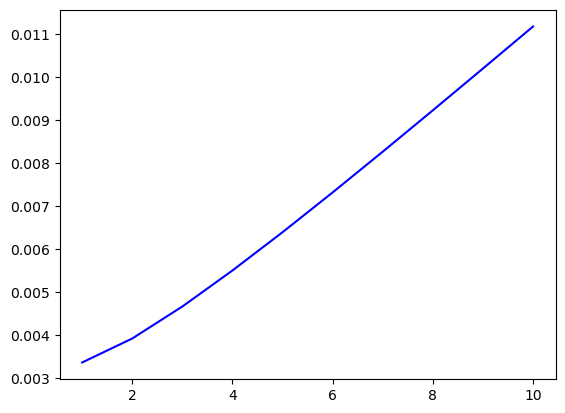

In [235]:
plt.plot(range(1, 11, 1), A, label='Sinkhorn', color='blue') # plot the minimal cost in function of the number of iterations

Finally, from this plot we can analyze that the convergence of the Sinkhorn algorithm toward the optimal minimization cost converges approaching the considered value from below.